In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_selection import mutual_info_regression

df = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

df.describe()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


In [2]:
df.Price

0        1480000.0
1        1035000.0
2        1465000.0
3         850000.0
4        1600000.0
           ...    
13575    1245000.0
13576    1031000.0
13577    1170000.0
13578    2500000.0
13579    1285000.0
Name: Price, Length: 13580, dtype: float64

In [3]:
df_2 = df.copy()
df_2 = df_2.dropna(axis=0)
output = df_2.Price

In [4]:
X = df_2.copy()
y = X.pop("Price")
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
discrete_features = X.dtypes == int
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Address          1.849493
BuildingArea     0.396788
Suburb           0.393434
Rooms            0.261188
Postcode         0.256207
Bedroom2         0.239204
CouncilArea      0.210831
Type             0.197194
Propertycount    0.183786
Bathroom         0.172640
SellerG          0.170023
Distance         0.169675
Landsize         0.167305
YearBuilt        0.159944
Lattitude        0.147919
Longtitude       0.146892
Regionname       0.100801
Method           0.099054
Car              0.088078
Date             0.016810
Name: MI Scores, dtype: float64

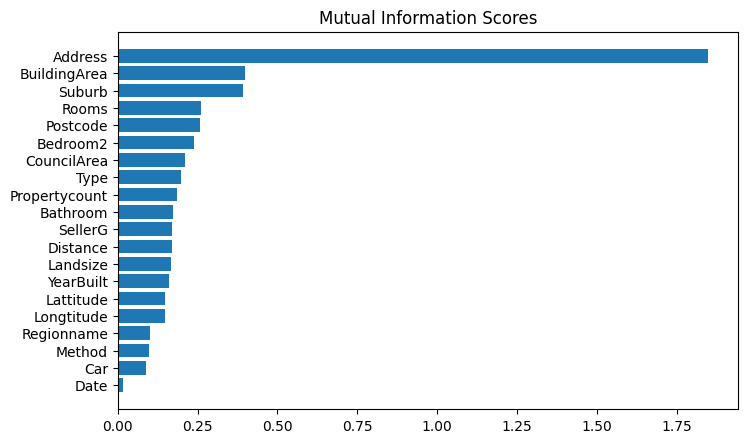

In [5]:
import matplotlib.pyplot as plt
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [6]:
features = ['Address','BuildingArea','Suburb','Postcode','Rooms','Bedroom2']
inputs = df_2[features]
inputs

,Address,BuildingArea,Suburb,Postcode,Rooms,Bedroom2
1,25 Bloomburg St,79.00,Abbotsford,3067.0,2,2.0
2,5 Charles St,150.00,Abbotsford,3067.0,3,3.0
4,55a Park St,142.00,Abbotsford,3067.0,4,3.0
6,124 Yarra St,210.00,Abbotsford,3067.0,3,4.0
7,98 Charles St,107.00,Abbotsford,3067.0,2,2.0
...,...,...,...,...,...,...
12205,30 Sherwin St,149.00,Whittlesea,3757.0,3,3.0
12206,75 Cecil St,115.00,Williamstown,3016.0,3,3.0
12207,2/29 Dover Rd,35.64,Williamstown,3016.0,1,1.0
12209,201/152 Peel St,61.60,Windsor,3181.0,2,2.0


In [7]:
from sklearn.tree import DecisionTreeRegressor

In [8]:
from sklearn.preprocessing import OneHotEncoder
s = (inputs.dtypes == 'object')
object_cols = list(s[s].index)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(inputs[object_cols]))
OH_cols_train.index = inputs.index
num_X_train = inputs.drop(object_cols, axis=1)
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_train.head()

,BuildingArea,Postcode,Rooms,Bedroom2,0,1,2,3,4,5,...,6394,6395,6396,6397,6398,6399,6400,6401,6402,6403
1,79.0,3067.0,2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,150.0,3067.0,3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,142.0,3067.0,4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,210.0,3067.0,3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,107.0,3067.0,2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X_train,output)

DecisionTreeRegressor(random_state=1)

In [10]:
print(model.predict(X_train))

[1035000. 1465000. 1600000. ...  385000.  560000. 2450000.]
